# Conformal Experiment: Increase Oracles
- OvA
- Softmax

In [1]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
n_classes = 10
n_experts = 10

# Metric Calculation

In [3]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else -1
        exp_prediction = ensemble_expert_pred_i[idx] if idx!=-1 else []
        
    return exp_prediction

## OvA

In [4]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_increase_oracle/"

k_list = np.arange(0,10)
seed = 948
for k in k_list:
    model_name = '_k_' + str(k)
    seed_name = 'seed_' + str(seed)
    with open(path + 'confidence_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

In [6]:
confs[0][11][10:]

tensor([0.2113, 0.1814, 0.2814, 0.1929, 0.2111, 0.2041, 0.2170, 0.2249, 0.1781,
        0.2733])

In [7]:
true[0][11]

9

In [8]:
n_val = int(0.8 * len(true[0]))
n_test = len(true[0]) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


In [9]:
k_list = np.arange(0,10)
alpha = 0.1
n_classes = 10
n_experts = 10
n_classes_exp = n_classes + n_experts


In [19]:
# Method dict ===
method_list_ova = ["standard", "last", "random", "voting"]
method_dict_ova = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_ova:
    print("Method: {}\n".format(method))
    for i, k in enumerate(k_list):
        # =============
        # = Get Probs =
        # =============
        set_size = []

        probs = confs[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")
        print("Q_hat {}: {}".format(k, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======
                    
                    set_size.append(len(prediction_set_i))



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1
            

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "set_size": set_size,
                    "avg_set_size": np.mean(set_size),
                    "q_hat": qhat}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict_ova[method].append(to_print)



Method: standard

Q_hat 0: 4.631767272949219
{'coverage': 98.15618221258134, 'system_accuracy': 86.06290672451193, 'expert_accuracy': 35.293910035823316, 'classifier_accuracy': 87.01656977809007, 'alone_classifier': 86.44251626898048, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(4.6318)}
Q_hat 1: 3.904437303543091
{'coverage': 84.11062906724511, 'system_accuracy': 76.46420824295011, 'expert_accuracy': 20.13650502627643, 'classifier_accuracy': 87.10508787201239, 'alone_classifier': 86.93058568329718, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(3.9044)}
Q_hat 2: 4.513142108917236
{'coverage': 80.53145336225596, 'system_accuracy': 73.15618221258134, 'expert_accuracy': 15.320325726838036, 'classifier_accuracy': 87.13804127016557, 'alone_classifier': 84.3817787418655, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(4.5131)}


/Users/dbarrejon/miniconda3/envs/l2d-conformal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dbarrejon/miniconda3/envs/l2d-conformal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Q_hat 3: 5.434385776519775
{'coverage': 65.18438177874187, 'system_accuracy': 63.286334056399134, 'expert_accuracy': 15.109029561049983, 'classifier_accuracy': 89.01829542277076, 'alone_classifier': 86.33405639913232, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(5.4344)}
Q_hat 4: 6.040248870849609
{'coverage': 57.59219088937093, 'system_accuracy': 60.19522776572668, 'expert_accuracy': 17.64705431021629, 'classifier_accuracy': 91.52541511060122, 'alone_classifier': 85.03253796095444, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(6.0402)}
Q_hat 5: 7.619450092315674
{'coverage': 48.7527114967462, 'system_accuracy': 56.127982646420826, 'expert_accuracy': 20.317456017469627, 'classifier_accuracy': 93.77084607665783, 'alone_classifier': 86.49674620390455, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(7.6195)}
Q_hat 6: 8.440417289733887
{'coverage': 49.45770065075922, 'system_accuracy': 57.48373101952278, 'expert_accuracy': 22.63948012028324, 'classifier_accuracy': 93.09

## Softmax

In [20]:
# === Softmax ===
n_classes = 10
probs_softmax = []
confs = []
exps = []
true = []

path = "softmax_increase_oracle/"
n_experts = 10
k_list = np.arange(0,10)
for k in k_list:
    model_name = '_k_' + str(k)
    seed_name = 'seed_' + str(seed)
    with open(path + 'confidence_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    print(c.shape)
    # DANI Correction ===
    c = c.softmax(dim=1)
    probs_softmax.append(c)
    # DANI Correction ===

    temp = 0
    for i in range(n_experts):
        temp += c[:, (n_classes + n_experts) - (i + 1)]
    prob = c / (1.0 - temp).unsqueeze(-1)
    confs.append(prob)


torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])


In [21]:
# Method dict ===
method_list_softmax = ["standard", "last", "random", "voting"]
method_dict_softmax = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_softmax:
                        
    set_size = []
    print("Method: {}\n".format(method))
    for i, k in enumerate(k_list):
        # =============
        # = Get Probs =
        # =============

        probs = probs_softmax[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        print("Q_hat {}: {}".format(k, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======
                    
                    set_size.append(len(prediction_set_i))



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "set_size": set_size,
                    "avg_set_size": np.mean(set_size),
                    "q_hat": qhat}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict_softmax[method].append(to_print)



Method: standard

Q_hat 0: 0.8156534433364868
{'coverage': 98.15618221258134, 'system_accuracy': 86.06290672451193, 'expert_accuracy': 35.293910035823316, 'classifier_accuracy': 87.01656977809007, 'alone_classifier': 86.44251626898048, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(0.8157)}
Q_hat 1: 0.7922136783599854
{'coverage': 84.11062906724511, 'system_accuracy': 76.46420824295011, 'expert_accuracy': 20.13650502627643, 'classifier_accuracy': 87.10508787201239, 'alone_classifier': 86.93058568329718, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(0.7922)}
Q_hat 2: 0.8086999654769897
{'coverage': 80.53145336225596, 'system_accuracy': 73.15618221258134, 'expert_accuracy': 15.320325726838036, 'classifier_accuracy': 87.13804127016557, 'alone_classifier': 84.3817787418655, 'set_size': [], 'avg_set_size': nan, 'q_hat': tensor(0.8087)}
Q_hat 3: 0.8378921151161194
{'coverage': 65.18438177874187, 'system_accuracy': 63.286334056399134, 'expert_accuracy': 15.109029561049983, 'class

## Plot results

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (7,7)


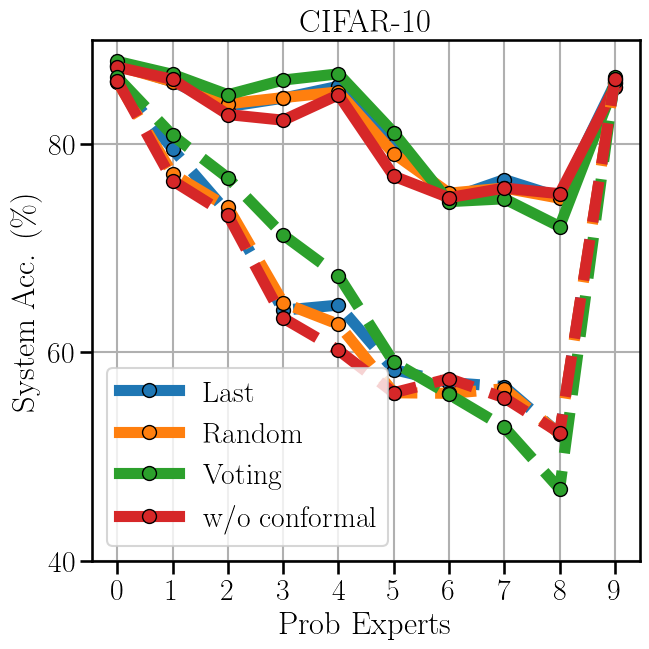

In [14]:
k_list = np.arange(0,10)


# OvA ===
sys_acc_standard_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["standard"]])
sys_acc_last_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["last"]])
sys_acc_random_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["random"]])
sys_acc_voting_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
sys_acc_standard_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["standard"]])
sys_acc_last_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["last"]])
sys_acc_random_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["random"]])
sys_acc_voting_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(k_list, sys_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(k_list, sys_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(k_list, sys_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(k_list, sys_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(k_list, sys_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(k_list, sys_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(k_list, sys_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(k_list, sys_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("system_acc_increase_oracles.pdf")

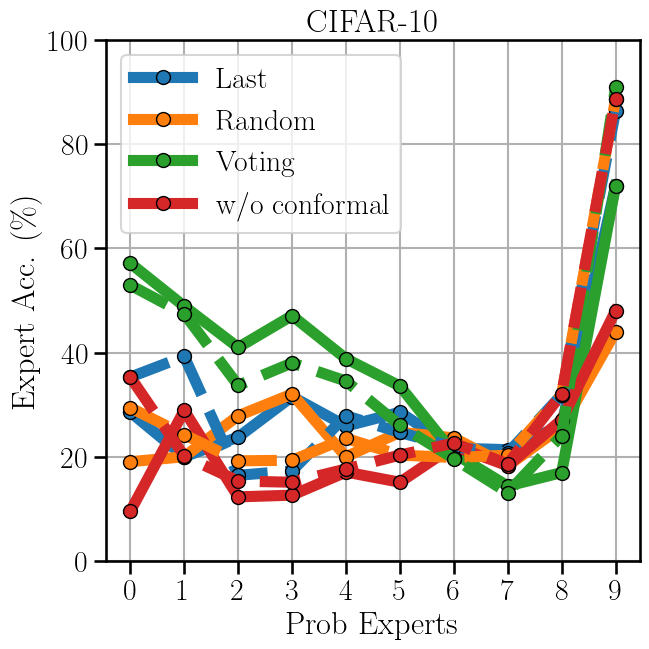

In [15]:
k_list

# OvA ===
exp_acc_standard_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["standard"]])
exp_acc_last_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["last"]])
exp_acc_random_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["random"]])
exp_acc_voting_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
exp_acc_standard_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["standard"]])
exp_acc_last_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["last"]])
exp_acc_random_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["random"]])
exp_acc_voting_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(k_list, exp_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(k_list, exp_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(k_list, exp_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(k_list, exp_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(k_list, exp_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(k_list, exp_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(k_list, exp_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(k_list, exp_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Expert Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("expert_acc_increase_oracles.pdf")


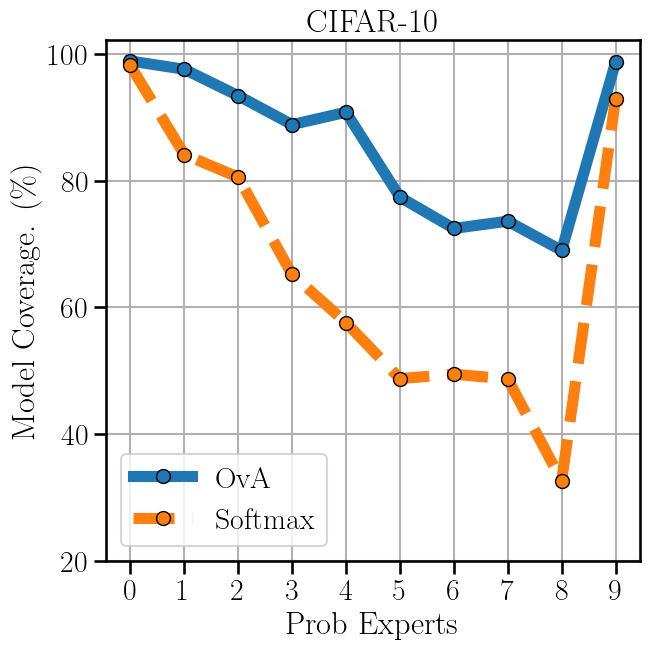

In [16]:
k_list
coverage_ova = np.array([method_d["coverage"] for method_d in method_dict_ova["last"]])
coverage_softmax = np.array([method_d["coverage"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, coverage_ova, "-", label=r"OvA", **plot_args)
ax.plot(k_list, coverage_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Model Coverage. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("coverage_increase_oracles.pdf")


In [17]:
np.array([np.mean(method_d["set_size"]) for method_d in method_dict_ova["voting"]])

array([9.66925768, 9.66925768, 9.66925768, 9.66925768, 9.66925768,
       9.66925768, 9.66925768, 9.66925768, 9.66925768, 9.66925768])

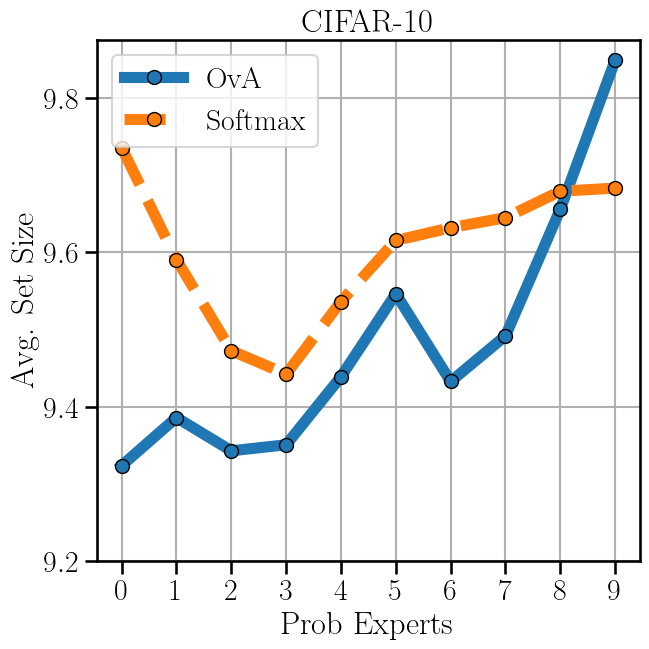

In [22]:
k_list
avg_set_size_ova = np.array([method_d["avg_set_size"] for method_d in method_dict_ova["last"]])
avg_set_size_softmax = np.array([method_d["avg_set_size"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, avg_set_size_ova, "-", label=r"OvA", **plot_args)
ax.plot(k_list, avg_set_size_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Avg. Set Size')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("avg_set_size_increase_oracles.pdf")


In [24]:
np.array([method_d["q_hat"] for method_d in method_dict_ova["last"]])

array([ 4.6317673,  3.9044373,  4.513142 ,  5.434386 ,  6.040249 ,
        7.61945  ,  8.440417 ,  8.962706 , 11.095672 ,  9.83402  ],
      dtype=float32)

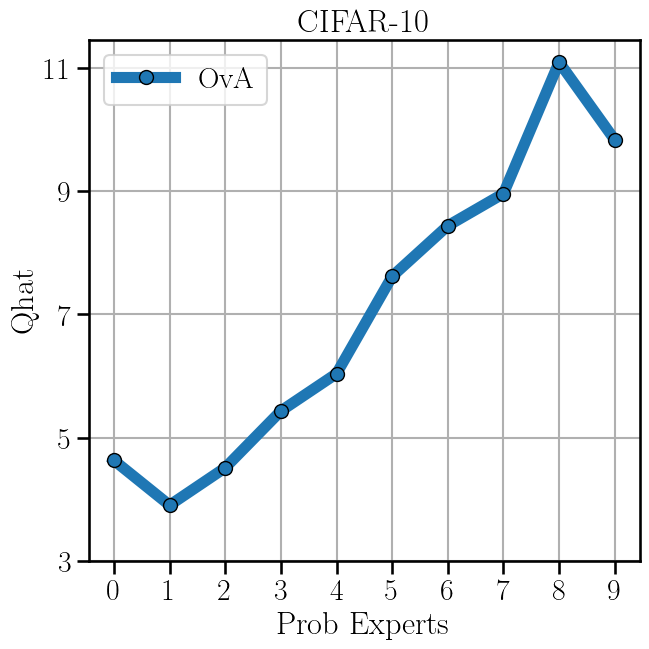

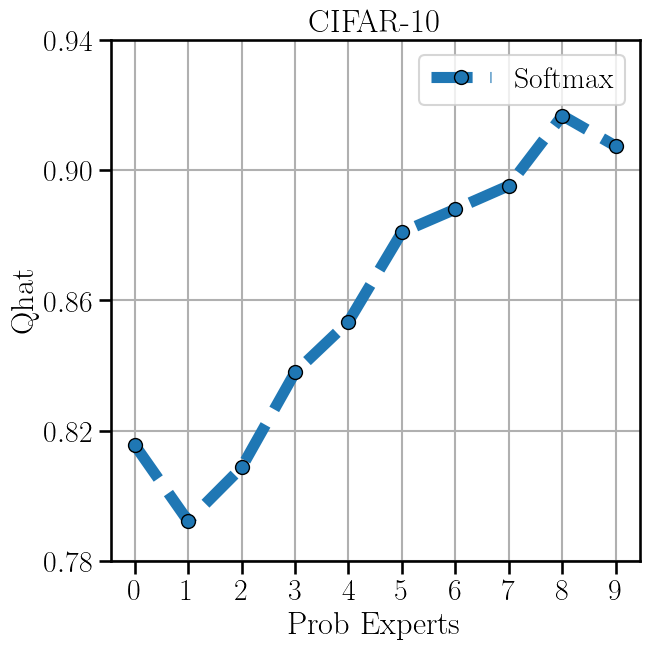

In [27]:
k_list
q_ova = np.array([method_d["q_hat"] for method_d in method_dict_ova["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, q_ova, "-", label=r"OvA", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Qhat')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("qhat_ova_increase_oracles.pdf")


q_ova_softmax = np.array([method_d["q_hat"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, q_ova_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Qhat')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("qhat_softmax_increase_oracles.pdf")
